In [ ]:
import sys
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.utils import resample

import joblib

# Add custom tokenizer path
sys.path.append(r'C:\Users\prash\OneDrive\Desktop\seventh semester\Project\Sentimental_Analysis\Website\backend')
from sentiment.tokenizer import nepali_tokenizer
from indicnlp.tokenize import indic_tokenize


In [70]:

nepali_stopwords = set([
    'अनि', 'अहिले', 'अरू', 'अर्को', 'अब', 'आफ्नो', 'इत्यादि', 'उनि', 'उसले', 'एक', 'एउटा',
    'एउटै', 'ओ', 'कति', 'कसैले', 'कसैलाई', 'कसैसँग', 'कसै', 'कसैको', 'कसको', 'कहिले',
    'कि', 'के', 'को', 'कोही', 'कोहीलाई', 'कोहीसँग', 'कुन', 'कुनै', 'कृपया', 'गरेको',
    'गर्छ', 'गर्नु', 'गरे', 'गर्छु', 'गरेछ', 'गरेका', 'गए', 'गएका', 'गएर', 'चाहिन्छ',
    'चाहे', 'जब', 'जहाँ', 'जे', 'त', 'तपाईं', 'तपाइँ', 'तपाइँले', 'तर', 'तिनी', 'तिनीहरू',
    'तिनीहरूलाई', 'तिनीहरूका', 'तिनीहरूको', 'ती', 'तीन', 'त्यो', 'त्स्याइ', 'दिएको', 'दिएर',
    'दुई', 'देखि', 'न', 'नभएको', 'नभए', 'नत्र', 'नजिकै', 'नाम', 'निकै', 'पनि', 'पर्छ',
    'पढ्ने', 'पारेर', 'पहिले', 'पनि', 'परेको', 'प्रति', 'फेरि', 'बनेको', 'बन्छ', 'बरु',
    'बाहेक', 'भएको', 'भएकाले', 'भएर', 'भने', 'भन्ने', 'भन्नु', 'भयो', 'भइ', 'भइरहेको',
    'म', 'मलाई', 'मेरो', 'हामी', 'हामीले', 'हाम्रो', 'हुन्छ', 'हुन्', 'हो', 'होइन', 'हरु',
    'संग', 'सक्ने', 'सबै', 'साथै', 'सधैं', 'समेत', 'सो', 'सोही', 'साथ', 'सिर्फ', 'सोधेको',
    'हुनु', 'हुन', 'थियो', 'थिए', 'थिइन्', 'थिएन', 'थाल्यो', 'तथा''छ', 'र', 'यो', 'लागि', 'मात्र', 'भित्र', 'पछि', 'अघि', 'बिच', 'दिन', 'आज', 'भोली',
    'कम', 'धेरै', 'अहँ', 'किन', 'कता', 'कहाँ'
])


In [71]:
# reading data from given path
df=pd.read_csv(r"archive (2).zip")
# Removing nto available data
df.dropna(subset=['Sentences'], inplace=True)
# Removing duplicated data
df.drop_duplicates(subset=['Sentences'], inplace=True)
print(df.columns)
# Clean Data
df.head()
print("Class Distribution:\n", df['Sentiment'].value_counts())




Index(['Unnamed: 0', 'Sentences', 'Sentiment'], dtype='object')
Class Distribution:
 Sentiment
 1    15857
-1    14393
 0     5482
Name: count, dtype: int64


In [72]:
# Clean Data

def clean_text(text):
    text = str(text)
   
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove links
    text = re.sub(r"[a-zA-Z]", "", text)                 # Remove English letters
    text = re.sub(r"[^\u0900-\u097F\s]", "", text)       # Remove everything except Nepali and spaces
    # text = re.sub(r"\d+", "", text) # Remove digits
    text = re.sub(r"[^\u0900-\u097F\s]", "", text)  # Remove punctuation & emojis
    text = re.sub(r"[0-9\u0966-\u096F]+", "", text)  # Remove Nepali and English digits 
    text=re.sub(r"।","",text) # remove |
    text = re.sub(r'\s+', ' ', text).strip()             # Normalize spaces
    
    return text
# Cleaning
df['clean_text'] = df['Sentences'].apply(clean_text)


# Show cleaned data
print(df[['Sentences', 'clean_text', 'Sentiment']].head())

                                           Sentences  \
0  म एक शिक्षक , शिक्षा क्षेत्रमा रमाएको मान्छे ।...   
1  म सरकारी स्कूल/कलेजमा पढेर करीब १२ बर्ष भन्दा ...   
2  कति राम्रो शिव मन्दिर देख्न पाइयो कुन ठाउको हो...   
3  मारुनी भन्ने वितिकै सामान्य नाचनीमा आधारित कथा...   
4  यो फ्लिम हेरिसकेपछी थाहा भयो कि किन दर्सकहरुले...   

                                          clean_text  Sentiment  
0  म एक शिक्षक शिक्षा क्षेत्रमा रमाएको मान्छे साम...          1  
1  म सरकारी स्कूलकलेजमा पढेर करीब बर्ष भन्दा बढी ...          1  
2  कति राम्रो शिव मन्दिर देख्न पाइयो कुन ठाउको हो...          1  
3  मारुनी भन्ने वितिकै सामान्य नाचनीमा आधारित कथा...          1  
4  यो फ्लिम हेरिसकेपछी थाहा भयो कि किन दर्सकहरुले...          1  


In [73]:
# # Tokenizing 
# def tokenization(sentence):
#     return sentence.split()
# # Applying the tokenization function
# df['token'] = df['clean_text'].apply(tokenization)
# print(df[["clean_text","token"]].head())

In [74]:
# # Tokenize each sentence using Indic NLP
from indicnlp.tokenize import indic_tokenize
def tokenization(sentence):
    return indic_tokenize.trivial_tokenize(sentence,lang="ne")
df["token"]=df["clean_text"].apply(tokenization)
print(df[["clean_text","token"]].head())

                                          clean_text  \
0  म एक शिक्षक शिक्षा क्षेत्रमा रमाएको मान्छे साम...   
1  म सरकारी स्कूलकलेजमा पढेर करीब बर्ष भन्दा बढी ...   
2  कति राम्रो शिव मन्दिर देख्न पाइयो कुन ठाउको हो...   
3  मारुनी भन्ने वितिकै सामान्य नाचनीमा आधारित कथा...   
4  यो फ्लिम हेरिसकेपछी थाहा भयो कि किन दर्सकहरुले...   

                                               token  
0  [म, एक, शिक्षक, शिक्षा, क्षेत्रमा, रमाएको, मान...  
1  [म, सरकारी, स्कूलकलेजमा, पढेर, करीब, बर्ष, भन्...  
2  [कति, राम्रो, शिव, मन्दिर, देख्न, पाइयो, कुन, ...  
3  [मारुनी, भन्ने, वितिकै, सामान्य, नाचनीमा, आधार...  
4  [यो, फ्लिम, हेरिसकेपछी, थाहा, भयो, कि, किन, दर...  


In [75]:
from collections import Counter
all_tokens = [token for tokens in df['token'] for token in tokens] #used for filter and normalize token
token_freq = Counter(all_tokens).most_common(100)  # Inspect top 100 tokens

In [76]:
# Stop word 
def remove_stopwords(tokens):
    return [word for word in tokens if word not in nepali_stopwords]

df['filtered_tokens'] = df['token'].apply(remove_stopwords)
print("Filtered token",df['filtered_tokens'])
print(df["filtered_tokens"].head())
# Show result
print(df[['Sentences', 'clean_text', 'token', 'filtered_tokens', 'Sentiment']].head())

Filtered token 0        [शिक्षक, शिक्षा, क्षेत्रमा, रमाएको, मान्छे, सा...
1        [सरकारी, स्कूलकलेजमा, पढेर, करीब, बर्ष, भन्दा,...
2        [राम्रो, शिव, मन्दिर, देख्न, पाइयो, ठाउको, होल...
3        [मारुनी, वितिकै, सामान्य, नाचनीमा, आधारित, कथा...
4        [फ्लिम, हेरिसकेपछी, थाहा, दर्सकहरुले, साम्राज्...
                               ...                        
35784    [कोरोना, भाइरसलाई, विश्व, स्वास्थ्य, संगठनले, ...
35785       [डब्ल्युएचओले, दियाेको, कोरोनाको, नयाँ, कोभिड]
35786           [कोरोना, भाइरस, संक्रमणको, औपचारिक, कोभिड]
35787    [विश्व, स्वास्थ्य, संगठन, डब्लुएचओ, ले, नोबल, ...
35788    [कोरोनाभाइरसका, सङ्क्रमणको, कोभिड, भनेर, विश्व...
Name: filtered_tokens, Length: 35732, dtype: object
0    [शिक्षक, शिक्षा, क्षेत्रमा, रमाएको, मान्छे, सा...
1    [सरकारी, स्कूलकलेजमा, पढेर, करीब, बर्ष, भन्दा,...
2    [राम्रो, शिव, मन्दिर, देख्न, पाइयो, ठाउको, होल...
3    [मारुनी, वितिकै, सामान्य, नाचनीमा, आधारित, कथा...
4    [फ्लिम, हेरिसकेपछी, थाहा, दर्सकहरुले, साम्राज्...
Name: fil

In [77]:
print(df['Sentiment'].dtype)
# Since Sentiment is already is in numerical value so we will not Perform LabelEncoder


int64


In [78]:
df['Sentiment'].value_counts()

Sentiment
 1    15857
-1    14393
 0     5482
Name: count, dtype: int64

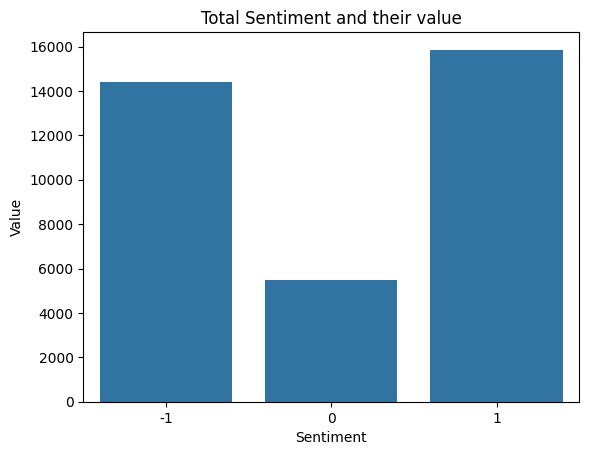

In [79]:
sns.countplot(x=df["Sentiment"])
plt.title("Total Sentiment and their value")
plt.xlabel("Sentiment")
plt.ylabel("Value")
plt.show()

In [80]:
df['token'] = df['clean_text'].apply(tokenization)
df['filtered_tokens'] = df['token'].apply(remove_stopwords)
df['processed_text'] = df['filtered_tokens'].apply(lambda x: ' '.join(x))

In [89]:
# TF-IDF on cleaned text

# Suppress the token_pattern warning
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.feature_extraction.text")
def nepali_tokenizer(text):
    return indic_tokenize.trivial_tokenize(text, lang='ne')
# TF-IDF on cleaned text
vectorizer = TfidfVectorizer(tokenizer=nepali_tokenizer,
                            token_pattern=None,ngram_range=(1,2))
X = vectorizer.fit_transform(df['processed_text'])
y = df['Sentiment']
print("TF-IDF Shape X",X.shape)

TF-IDF Shape X (35732, 345600)


In [90]:


# Manual oversampling of neutral class
df_positive = df[df['Sentiment'] == 1]
df_negative = df[df['Sentiment'] == -1]
df_neutral = df[df['Sentiment'] == 0]

# Oversample neutral class to match positive class
df_neutral_upsampled = resample(df_neutral, replace=True, n_samples=len(df_positive), random_state=42)

# Combine classes
df_balanced = pd.concat([df_positive, df_negative, df_neutral_upsampled])

# Verify class distribution before vectorization
print("Class distribution after oversampling:", df_balanced['Sentiment'].value_counts())

Class distribution after oversampling: Sentiment
 1    15857
 0    15857
-1    14393
Name: count, dtype: int64


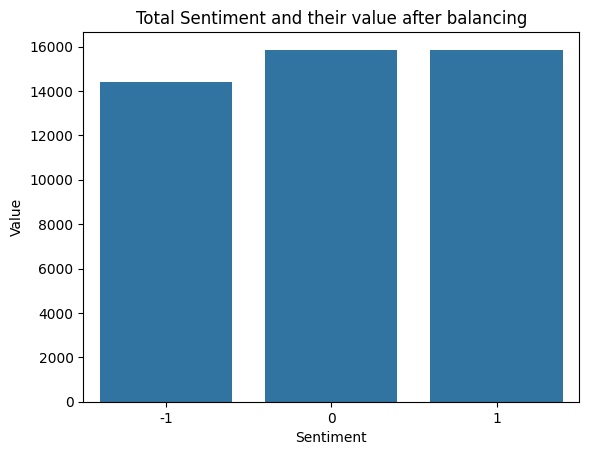

In [91]:
sns.countplot(x=df_balanced["Sentiment"])
plt.title("Total Sentiment and their value after balancing")
plt.xlabel("Sentiment")
plt.ylabel("Value")
plt.show()

In [92]:
# TF-IDF vectorization




vectorizer = TfidfVectorizer(
    tokenizer=nepali_tokenizer,
    token_pattern=None,
    max_df=0.95,
    min_df=5,
        ngram_range=(1, 2)
)

X = vectorizer.fit_transform(df_balanced['processed_text'])
y = df_balanced['Sentiment']

In [93]:
X.shape # since no.of sample > no.of features of setting dual=False in linearSVM

(46107, 37419)

In [94]:
print("Class distribution of y:", pd.Series(y).value_counts())

Class distribution of y: Sentiment
 1    15857
 0    15857
-1    14393
Name: count, dtype: int64


In [95]:
# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

Custom SVM Accuracy: 0.5197354153112124
Custom SVM Classification Report:
               precision    recall  f1-score   support

    Negative       0.60      0.41      0.49      2871
     Neutral       0.46      0.73      0.57      3191
    Positive       0.58      0.41      0.48      3160

    accuracy                           0.52      9222
   macro avg       0.55      0.52      0.51      9222
weighted avg       0.55      0.52      0.51      9222



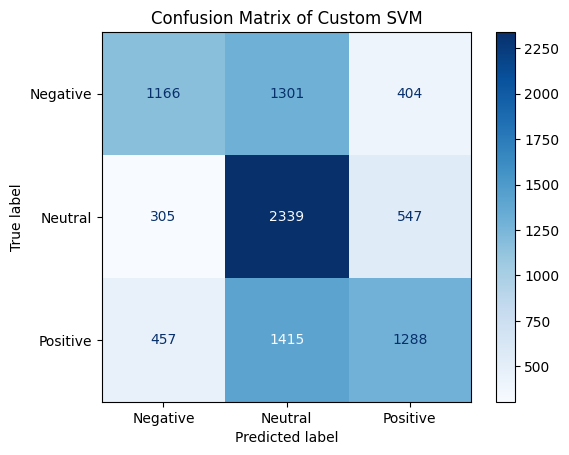

Custom SVM Cross-Validation Scores: [0.42 0.47 0.49 0.54 0.56]
Custom SVM Mean Accuracy: 0.496


In [88]:

# Convert y_train and y_test to NumPy arrays to avoid index issues
y_train_np = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train
y_test_np = y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test

# Feature selection on sparse data to reduce features
selector = SelectKBest(chi2, k=1000)  # Select top 1000 features
X_train_sparse_reduced = selector.fit_transform(X_train, y_train_np)
X_test_sparse_reduced = selector.transform(X_test)

# Subsample before dense conversion
np.random.seed(42)
subsample_indices = np.random.choice(X_train_sparse_reduced.shape[0], size=500, replace=False)
X_train_subsample_sparse = X_train_sparse_reduced[subsample_indices]
y_train_subsample = y_train_np[subsample_indices]  # Use NumPy array for consistent indexing

# Convert to dense
try:
    X_train_subsample = X_train_subsample_sparse.toarray()  
    X_test_dense = X_test_sparse_reduced.toarray() 
except MemoryError:
    print("Error : Memory error")
    raise

# Scale features
scaler = StandardScaler()
X_train_subsample = scaler.fit_transform(X_train_subsample)
X_test_dense = scaler.transform(X_test_dense)

# Custom SVM Implementation
class CustomBinarySVM(BaseEstimator):
    def __init__(self, learning_rate=0.001, lambda_param=0.1, n_iters=1000, class_weight_pos=1.0, class_weight_neg=1.0):
        self.lr = learning_rate  # Step size for gradient updates
        self.lambda_param = lambda_param  # Regularization strength
        self.n_iters = n_iters  # Number of iterations
        self.class_weight_pos = class_weight_pos  # Weight for +1 class (e.g., neutral)
        self.class_weight_neg = class_weight_neg  # Weight for -1 class (rest)
        self.weights = None  # Weight vector
        self.bias = None  # Bias term

    def fit(self, X, y):
        n_samples, n_features = X.shape  # Get data dimensions
        self.weights = np.zeros(n_features)  # Initialize weights to zero
        self.bias = 0  # Initialize bias to zero
        for _ in range(self.n_iters):  # Loop over 50 iterations
            for idx, x_i in enumerate(X):  # Loop over samples
                y_i = y[idx]  # Get label (+1 or -1)
                prediction = np.dot(x_i, self.weights) + self.bias  # Compute w.x + b
                condition = y_i * prediction >= 1  # Check if correctly classified with margin
                if not condition:  # If misclassified or in margin
                    weight = self.class_weight_pos if y_i == 1 else self.class_weight_neg
                    self.weights -= self.lr * (2 * self.lambda_param * self.weights - weight * y_i * x_i)  # Update weights
                    self.bias -= self.lr * (-weight * y_i)  # Update bias
                else:  # Only regularization
                    self.weights -= self.lr * (2 * self.lambda_param * self.weights)
        return self

    def decision_function(self, X):
        return np.dot(X, self.weights) + self.bias  # Compute scores for prediction

    def get_params(self, deep=True):
        return {
            'learning_rate': self.lr,
            'lambda_param': self.lambda_param,
            'n_iters': self.n_iters,
            'class_weight_pos': self.class_weight_pos,
            'class_weight_neg': self.class_weight_neg
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

class CustomMultiClassSVM(BaseEstimator):
    def __init__(self, learning_rate=0.001, lambda_param=0.1, n_iters=1000, class_weights=None):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.class_weights = class_weights or {-1: 1.0, 0: 2.0, 1: 1.0}  # Higher weight for neutral
        self.classes = None
        self.classifiers = {}

    def fit(self, X, y):
        self.classes = np.unique(y)  # Get classes (-1, 0, 1)
        for c in self.classes:  # Train one SVM per class
            y_binary = np.where(y == c, 1, -1)  # Binary labels for OvR
            weight_pos = self.class_weights.get(c, 1.0)  # Weight for class c
            weight_neg = 1.0  # Weight for rest
            binary_svm = CustomBinarySVM(self.lr, self.lambda_param, self.n_iters, weight_pos, weight_neg)
            binary_svm.fit(X, y_binary)  # Train binary SVM
            self.classifiers[c] = binary_svm  # Store classifier
        return self

    def predict(self, X):
        scores = np.array([clf.decision_function(X) for clf in self.classifiers.values()]).T  # Scores for each class
        return self.classes[np.argmax(scores, axis=1)]  # Choose highest score class

    def get_params(self, deep=True):
        return {
            'learning_rate': self.lr,
            'lambda_param': self.lambda_param,
            'n_iters': self.n_iters,
            'class_weights': self.class_weights
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

# Train custom SVM
class_weights = {-1: 1.0, 0: 2.0, 1: 1.0}  # Emphasize neutral
model_custom = CustomMultiClassSVM(class_weights=class_weights)
model_custom.fit(X_train_subsample, y_train_subsample)

# Evaluate
y_pred_custom = model_custom.predict(X_test_dense)
print("Custom SVM Accuracy:", accuracy_score(y_test_np, y_pred_custom))
print("Custom SVM Classification Report:\n", classification_report(y_test_np, y_pred_custom, target_names=['Negative', 'Neutral', 'Positive']))

cm_custom = confusion_matrix(y_test_np, y_pred_custom)
disp_custom = ConfusionMatrixDisplay(confusion_matrix=cm_custom, display_labels=['Negative', 'Neutral', 'Positive'])
disp_custom.plot(cmap='Blues')
plt.title("Confusion Matrix of Custom SVM")
plt.show()

# Cross-Validation (on subsample for speed)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
custom_scores = cross_val_score(model_custom, X_train_subsample, y_train_subsample, cv=kf, scoring='accuracy')
print("Custom SVM Cross-Validation Scores:", custom_scores)
print("Custom SVM Mean Accuracy:", np.mean(custom_scores))

In [96]:
# # Train SVM with custom class weights
class_weights = {-1: 1, 0: 1, 1: 1}  # Emphasize neutral class

model = LinearSVC(class_weight="balanced", C=1.0,dual=False, max_iter=1000)
model.fit(X_train, y_train)

LinearSVC(class_weight='balanced', dual=False)

In [97]:
print(X_train.shape)
print(X_test.shape)

(36885, 37419)
(9222, 37419)


In [98]:
# Step 4: Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.808067664281067
Classification Report:
               precision    recall  f1-score   support

          -1       0.79      0.74      0.76      2871
           0       0.83      0.91      0.87      3191
           1       0.80      0.76      0.78      3160

    accuracy                           0.81      9222
   macro avg       0.81      0.81      0.80      9222
weighted avg       0.81      0.81      0.81      9222



In [99]:
# Kfold Cross validation

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
print("Cross-Validation Scores:", svm_scores)
print("Mean Accuracy:", np.mean(svm_scores))

Cross-Validation Scores: [0.80969421 0.80687486 0.80717926 0.80923978 0.80468496]
Mean Accuracy: 0.8075346151377518


In [30]:
# Testing the model
user_input = input("नेपाली वाक्य लेख्नुहोस्: (Enter a Nepali sentence) ")  # Enter a Nepali sentence
user_vector = vectorizer.transform([user_input])
prediction = model.predict(user_vector)[0]

sentiment_map = {-1: "Negative (नकारात्मक)", 0: "Neutral (तटस्थ)", 1: "Positive (सकारात्मक)"}
print("पूर्वानुमान गरिएको भावना:", sentiment_map.get(prediction, "Unknown"))



नेपाली वाक्य लेख्नुहोस्: (Enter a Nepali sentence)  44


पूर्वानुमान गरिएको भावना: Neutral (तटस्थ)


In [46]:
joblib.dump(vectorizer, 'vectorizer.joblib')

['vectorizer.joblib']

In [47]:
joblib.dump(model, 'sentiment_model.joblib')

['sentiment_model.joblib']

In [22]:
print(df['Sentiment'].value_counts())


Sentiment
 1    15857
-1    14393
 0     5482
Name: count, dtype: int64


In [23]:

joblib.dump(vectorizer, r'D:\Sentimental_Analysis\Website\backend\sentiment/vectorizer.joblib')



['D:\\Sentimental_Analysis\\Website\\backend\\sentiment/vectorizer.joblib']

In [24]:
joblib.dump(model, r'D:\Sentimental_Analysis\Website\backend\sentiment/sentiment_model.joblib')

['D:\\Sentimental_Analysis\\Website\\backend\\sentiment/sentiment_model.joblib']

In [100]:
from sklearn.linear_model import LogisticRegression
model_lg = LogisticRegression(max_iter=1000,class_weight="balanced")
model_lg.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [101]:

lg_pred=model_lg.predict(X_test)

In [102]:
print("Classification report : \n",classification_report(y_test,lg_pred))

Classification report : 
               precision    recall  f1-score   support

          -1       0.78      0.72      0.75      2871
           0       0.78      0.85      0.81      3191
           1       0.78      0.76      0.77      3160

    accuracy                           0.78      9222
   macro avg       0.78      0.78      0.78      9222
weighted avg       0.78      0.78      0.78      9222



In [103]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lg_scores = cross_val_score(model_lg, X, y, cv=kf, scoring='accuracy')
print("Cross-Validation Scores:", lg_scores)
print("Mean Accuracy:", np.mean(lg_scores))

Cross-Validation Scores: [0.78681414 0.77770549 0.78429671 0.78635723 0.77323501]
Mean Accuracy: 0.7816817152233602


In [104]:
# NavieBayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(class_weight="balanced" ,y=y_train)

model_nb = MultinomialNB()
model_nb.fit(X_train, y_train, sample_weight=sample_weights)

MultinomialNB()

In [105]:
nb_ypred=model_nb.predict(X_test)
print(classification_report(y_test, nb_ypred))

              precision    recall  f1-score   support

          -1       0.70      0.71      0.71      2871
           0       0.86      0.67      0.75      3191
           1       0.67      0.82      0.74      3160

    accuracy                           0.73      9222
   macro avg       0.75      0.73      0.73      9222
weighted avg       0.75      0.73      0.73      9222



In [106]:

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nb_scores = cross_val_score(model_nb, X, y, cv=kf, scoring='accuracy')
print("Cross-Validation Scores:", nb_scores)
print("Mean Accuracy:", np.mean(nb_scores))

Cross-Validation Scores: [0.72977662 0.72327044 0.7362542  0.72844594 0.72985576]
Mean Accuracy: 0.7295205932748862


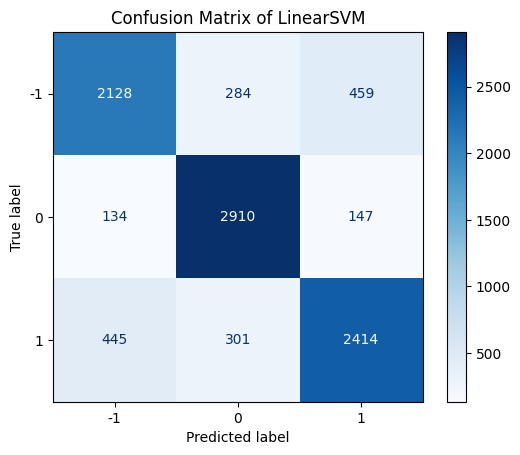

In [107]:
# Confusion matrix for true positive ,true negative,false positive ,false negative for LinearSVM


# Confusion matrix
cm = confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[-1, 0, 1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix of LinearSVM")
plt.show()

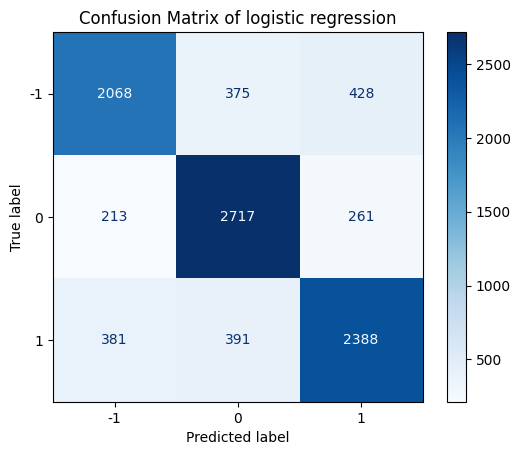

In [108]:
# Confusion matrix
cm = confusion_matrix(y_test,lg_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[-1, 0, 1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix of logistic regression")
plt.show()

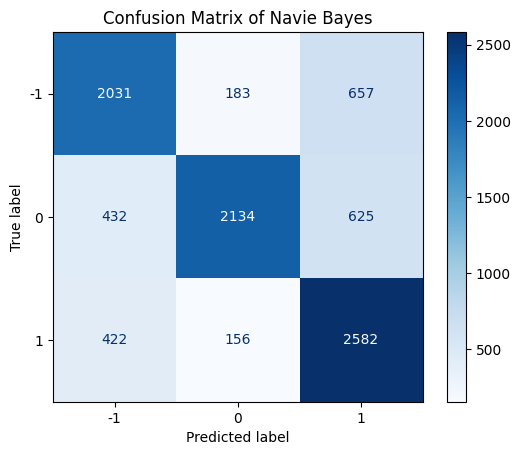

In [109]:
# Confusion matrix
cm = confusion_matrix(y_test,nb_ypred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[-1, 0, 1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix of Navie Bayes")
plt.show()